# Image matching and panorama detection
This notebook implements the first half of the paper "Automatic Panoramic Image Stitching using Invariant features".

## Principle
The goal is to produce subsets of images that overlap each other, from an unordered unlabeled set of images. These subsets can then be stitched together to make panoramas.

The first step is to compute SIFT features in all the images, then match all of these features to their k closest neighbors. This is meant to produce a first guess of "possible matches". These guesses are then refined by computing homographies between possible matches, and using the inlier rations to remove false positive matches.

In [1]:
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tqdm
import cv2 as cv
import numpy as np
from PIL import Image

# Plot images or not
debug = True

# we will store most of the useful information in a main array, with one element per image.
# we define some aliases for accessing these arrays
IMAGE = 0
KEYP = 1
DESC = 2 

## SIFT feature extraction
The first step is to extract and match SIFT features accros images. Since SIFT features are invariant to rotation and scale, this allows the method to handle images with varying rotation and zoom.
Since multiple images can overlap a single ray, we match each feature to its $k = 4$ nearest neighbors in feature space. This is done in $O(nlogn)$ time using a k-d tree.

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.61it/s]


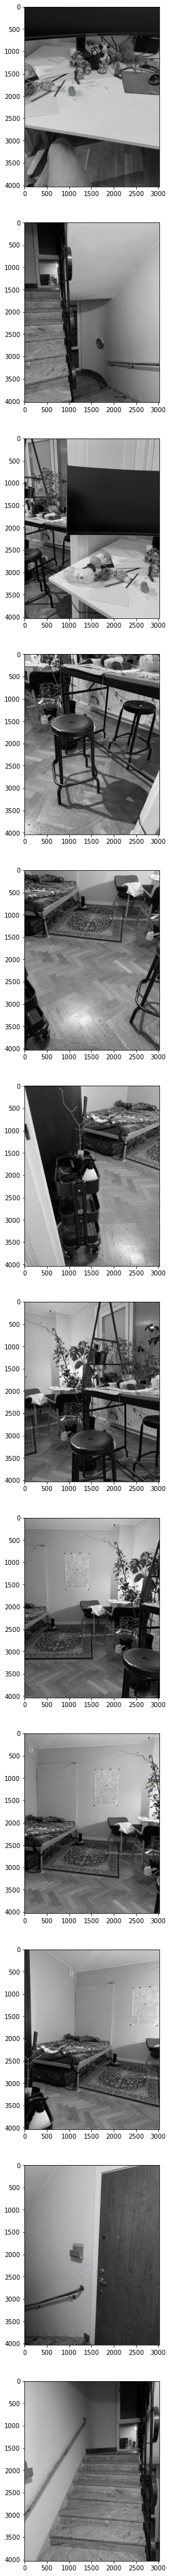

In [2]:
# 1. Load set of images
images = []
for filename in tqdm.tqdm(glob.glob("images/*.jpg")):
    """
    size = 400,400
    im = Image.open(filename)
    im.thumbnail(size, Image.ANTIALIAS)
    images.append([np.array(im)])
    """
    
    img = imread(filename)
    images.append([img])
    
nb_images = len(images)
nb_features = 1000
    
# 2. Get SIFT features for each image
# keypoints = 2D coordinates of the features
# descriptors = vectors of 128 ints, one per feature
sift = cv.SIFT_create(nfeatures = nb_features)
for i in tqdm.tqdm(range(nb_images)):
    image = images[i][0]
    kp, desc = sift.detectAndCompute(image,None)
    images[i].append(kp[:nb_features])
    images[i].append(desc[:nb_features])
    
if debug:
    fig, axs = plt.subplots(nb_images, figsize=(50,75))
    for i in tqdm.tqdm(range(nb_images)):
        image = images[i][IMAGE]
        gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        img = np.empty_like(image)
        kp = images[i][KEYP]
        img = cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axs[i].imshow(img)
    fig.show()

In [3]:
# 3. Compute Kd tree from ALL the descriptors
# http://www.cs.ubc.ca/~lowe/papers/cvpr97.pdf
from scipy.spatial import KDTree
data = np.empty((nb_images, nb_features, 128))

for i in tqdm.tqdm(range(nb_images)):
    data[i] = images[i][DESC][:nb_features]

# the data needs to be shaped as (m, n) with
# m = number of descriptors, here m = nb_features * nb_images
# n = length of one descriptor, here 128 as we use SIFT
T = KDTree(data.reshape(-1, 128))

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 5154.29it/s]


## Image matching
### Binning feature matches

By matching all the features to their k nearest neighbors, we can identify images that have high overlap with each other.
To do so, we build an histogram of feature matches, that counts for each image to which images its features got matched.
For a given image, we can then decide to only study the $m = 6$ images that have the most matched features with it. This reduces the search space.

In [4]:
# Identify images that have a large number of matches between them
# For a given image, each feature is matched to its k = 4 nearest neighbors
# accross all images. We can then know to which image they belong.
def match_all_descriptors(T, image_desc):
    """
    For a given list of descriptors computed for an image, finds their k nearest neighbors
    and returns a sorted list of image indices from which the neighors belong (histogram).
    
    T: kd tree with all the descriptors to compare to
    image_desc: list of descriptors for a given image (shape: (nb_features, 128))
    """
    # We know that T was built with data in shape (nb_images * nb_features, 128), 
    # so if we know a matching index i, we can get the image index by dividing by nb_features.
    nb_features = len(image_desc)
    matches = [0] * nb_images # each cell = number of matches that correspond to that image.
    for desc_idx in range(nb_features):
        dd, ii = T.query(image_desc[desc_idx].flatten(), k = 4)
        for neighbor_idx in ii:
            matches[neighbor_idx // nb_features] += 1
    # Convert the matches bins into a dict so that we can sort it by number of matches while
    # remembering the image indices
    matches = {k: v for k, v in enumerate(matches)}
    matches = {k: v for k, v in sorted(matches.items(), key=lambda item: -item[1])}
    return matches

{5: 2233, 4: 319, 9: 268, 1: 180, 3: 172, 6: 144, 11: 136, 7: 135, 8: 129, 2: 112, 0: 88, 10: 84}


 25%|█████████████████████                                                               | 3/12 [00:00<00:01,  6.18it/s]


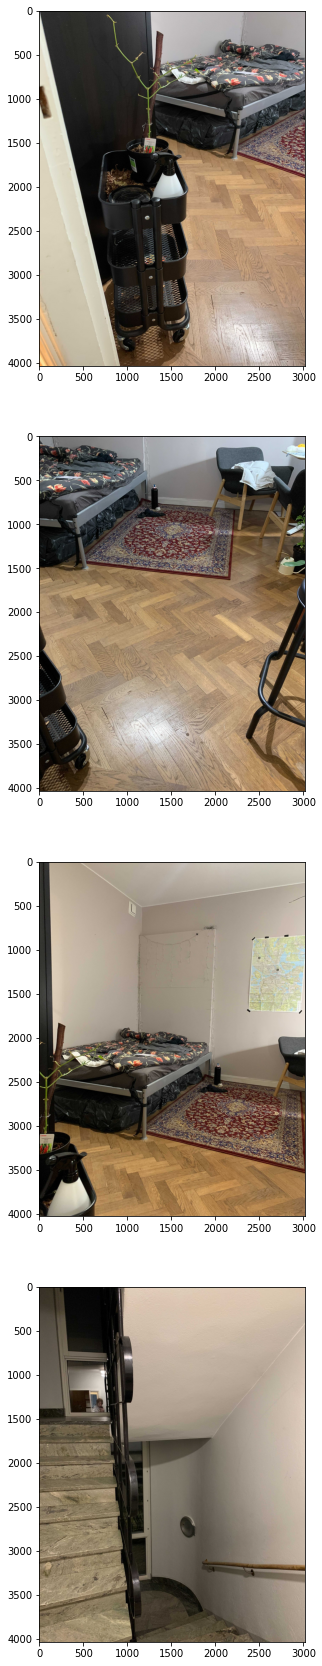

In [5]:
# Look at which images share the most features with image 5.
imgidx = 5
matches = match_all_descriptors(T, images[imgidx][2])
print(matches)

debug = True
if debug:
    fig, axs = plt.subplots(4, figsize=(20,30))
    i = 0
    for k,v in tqdm.tqdm(matches.items()):
        image = images[k][0]
        axs[i].imshow(image)
        i+=1
        if i == 4:
            break
    fig.show()

### Homography estimation using RANSAC
We refine the matching on the aforementioned $m = 6$ possible matches for each image.
To do so, we match features between each couple of images and use them to compute a homography using ransac.

We can then use the RANSAC inliers to compute a probabilistic model that the two images are indeed matches.
To do so, we consider the probability that a set of inliers / outliers is produced by matching images.

For a given image .
- we denote the number of inliers $n_i$ and the number of features in the area of overlap $n_f$.
- $m \in {0,1}$ represents the event that two images match.
- the event that the $i^{th}$ feature match $f^{(i)}$ is an outlier / inlier is an independant Bernouilli variable.


Therefore, the total number of inliers is binomial and we can write the probability of inlier / outlier as
$$
\begin{equation}
p(f^{(1:n_f)} | m = 1) = B(n_i, n_f, p_1) \\
p(f^{(1:n_f)} | m = 0) = B(n_i, n_f, p_0) \\
\end{equation}
$

Where 
- $B(.)$ being the binomial distribution
- $p_0$ is the probability that a feature is an inlier given a wrong match. We chose $p_0 = 0.1$.
- $p_1$ is the probability that a feature is an inlier given a good match. We chose $p_1 = 0.6$.

Using Baye's rule, we can compute the posterior probability that an image is a correct match given a feature, and then chose a threshold of "acceptance" (ie if that probability is higher than the threshold then the image is a match).

From that threshold, we derive the condition $n_i > \alpha + \beta n_f$ for a correct match, with $\alpha = 8$ and $\beta = 0.3$.

This condition allows us to assign the final pairwise image matches.

In [6]:
# Threshold to dertermine if two images match by looking at the ransac inliers
# ni = number of inliers
# nf = all points
ismatch = lambda ni, nf: ni > 8.0 + 0.3 * nf

In [13]:
def get_opencv_matches(img1, img2):
    """
    Helper function that matches features between two images.
    It would be more satisfying to do this without an openCV matcher, just like
    above.
    We could either:
    a) Save all the matches in the previous function instead of just the indices
    b) Rewrite this function, building the tree just as before but just for 2 images
    The best would be a), ie in the first step we save at the very least what was the closest neighbor
    of each match (save both image index and feature)
    """
    # temp func to get keypoint matches between two images
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(desc1,desc2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            
            
    #https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
    list_kp1 = []
    list_kp2 = []
    for mat in good:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt
        

        # Append to each list
        list_kp1.append((x1, y1))
        list_kp2.append((x2, y2))

    return np.array(list_kp1), np.array(list_kp2)

In [14]:
# Now for each image, we look at the m most matching pairs and compute a homography
# Compute between all kp or only the matched kp ?
# the array homographies will contain features information,
# and the Homography computation with (at most) each of the m
# closest matches to every image. shape = (nb_images, {0 - 6})
m = 6
homographies = []
for imgidx in tqdm.tqdm(range(len(images))):
    # Query the tree and get matches 
    matches = match_all_descriptors(T, images[imgidx][2])
    #curr_img_kp = np.array([x.pt for x in images[imgidx][1]])
    i = 0
    h_list = []
    for k,v in matches.items():
        if k != imgidx:
            #matched_img_kp = np.array([x.pt for x in images[k][1]])
            #H, mask = cv.findHomography(curr_img_kp, matched_img_kp, cv.RANSAC)
            #print(f"Inliers between {imgidx} and {k}: {100 * mask.mean():.2f}")
            curr_img_kp, matched_img_kp = get_opencv_matches(images[imgidx][0], images[k][0])
            if np.shape(curr_img_kp)[0] >= 4:
                H, mask = cv.findHomography(curr_img_kp, matched_img_kp, cv.RANSAC)
                h_list.append([k, H, mask, curr_img_kp, matched_img_kp])
                if debug:
                    print(f"Inliers between {imgidx} and {k}: {100 * mask.mean():.2f}")

            i += 1
        if i == m:
            break
            
    homographies.append(h_list)

  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

Inliers between 0 and 2: 35.15
Inliers between 0 and 11: 13.79
Inliers between 0 and 1: 18.75
Inliers between 0 and 10: 13.04
Inliers between 0 and 3: 12.90


  8%|███████                                                                             | 1/12 [01:24<15:34, 84.93s/it]

Inliers between 0 and 7: 11.11
Inliers between 1 and 11: 54.51
Inliers between 1 and 10: 16.47
Inliers between 1 and 2: 14.29
Inliers between 1 and 3: 16.13
Inliers between 1 and 0: 12.77


 17%|██████████████                                                                      | 2/12 [03:06<15:47, 94.71s/it]

Inliers between 1 and 5: 18.52
Inliers between 2 and 0: 34.67
Inliers between 2 and 3: 22.64
Inliers between 2 and 11: 15.89
Inliers between 2 and 1: 19.23
Inliers between 2 and 6: 22.94


 25%|█████████████████████                                                               | 3/12 [04:26<13:12, 88.08s/it]

Inliers between 2 and 10: 18.10
Inliers between 3 and 6: 41.49
Inliers between 3 and 2: 17.07
Inliers between 3 and 7: 50.56
Inliers between 3 and 11: 7.09
Inliers between 3 and 5: 6.67


 33%|███████████████████████████▋                                                       | 4/12 [07:00<15:13, 114.19s/it]

Inliers between 3 and 4: 43.88
Inliers between 4 and 9: 73.41
Inliers between 4 and 8: 61.12
Inliers between 4 and 5: 51.79
Inliers between 4 and 6: 63.27
Inliers between 4 and 1: 12.16


 42%|██████████████████████████████████▌                                                | 5/12 [11:56<20:57, 179.58s/it]

Inliers between 4 and 7: 75.85
Inliers between 5 and 4: 54.72
Inliers between 5 and 9: 55.01
Inliers between 5 and 1: 15.73
Inliers between 5 and 3: 8.82
Inliers between 5 and 6: 7.58


 50%|█████████████████████████████████████████▌                                         | 6/12 [14:05<16:14, 162.49s/it]

Inliers between 5 and 11: 6.67
Inliers between 6 and 7: 49.11
Inliers between 6 and 8: 36.30
Inliers between 6 and 3: 41.80
Inliers between 6 and 4: 59.43
Inliers between 6 and 2: 15.58


 58%|████████████████████████████████████████████████▍                                  | 7/12 [16:22<12:49, 153.96s/it]

Inliers between 6 and 5: 13.01
Inliers between 7 and 6: 48.25
Inliers between 7 and 8: 61.07
Inliers between 7 and 3: 50.81
Inliers between 7 and 4: 75.14
Inliers between 7 and 9: 70.77


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [19:12<10:36, 159.05s/it]

Inliers between 7 and 2: 9.68
Inliers between 8 and 7: 63.72
Inliers between 8 and 6: 42.75
Inliers between 8 and 9: 64.81
Inliers between 8 and 4: 64.77
Inliers between 8 and 3: 45.57


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [21:59<08:04, 161.62s/it]

Inliers between 8 and 5: 65.02
Inliers between 9 and 4: 66.79
Inliers between 9 and 8: 74.68
Inliers between 9 and 5: 56.95
Inliers between 9 and 7: 61.30
Inliers between 9 and 1: 7.46


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [24:28<05:15, 157.84s/it]

Inliers between 9 and 3: 7.25
Inliers between 10 and 1: 41.18
Inliers between 10 and 11: 33.33
Inliers between 10 and 0: 41.67
Inliers between 10 and 2: 26.67
Inliers between 10 and 9: 40.00


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [25:04<02:00, 120.36s/it]

Inliers between 10 and 3: 66.67
Inliers between 11 and 1: 48.43
Inliers between 11 and 10: 18.46
Inliers between 11 and 2: 12.82
Inliers between 11 and 3: 13.16
Inliers between 11 and 0: 11.54


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [25:57<00:00, 129.79s/it]

Inliers between 11 and 5: 13.79


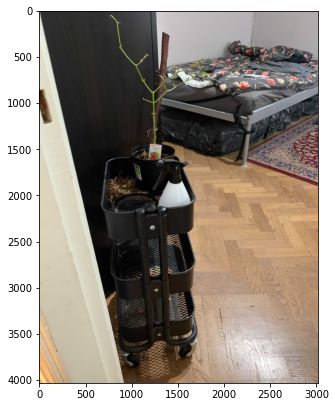

matches
4 0.5471698113207547 2385 True
9 0.5501199040767386 2085 True
1 0.15730337078651685 89 False
3 0.08823529411764706 68 False
6 0.07575757575757576 66 False
11 0.06666666666666667 105 False


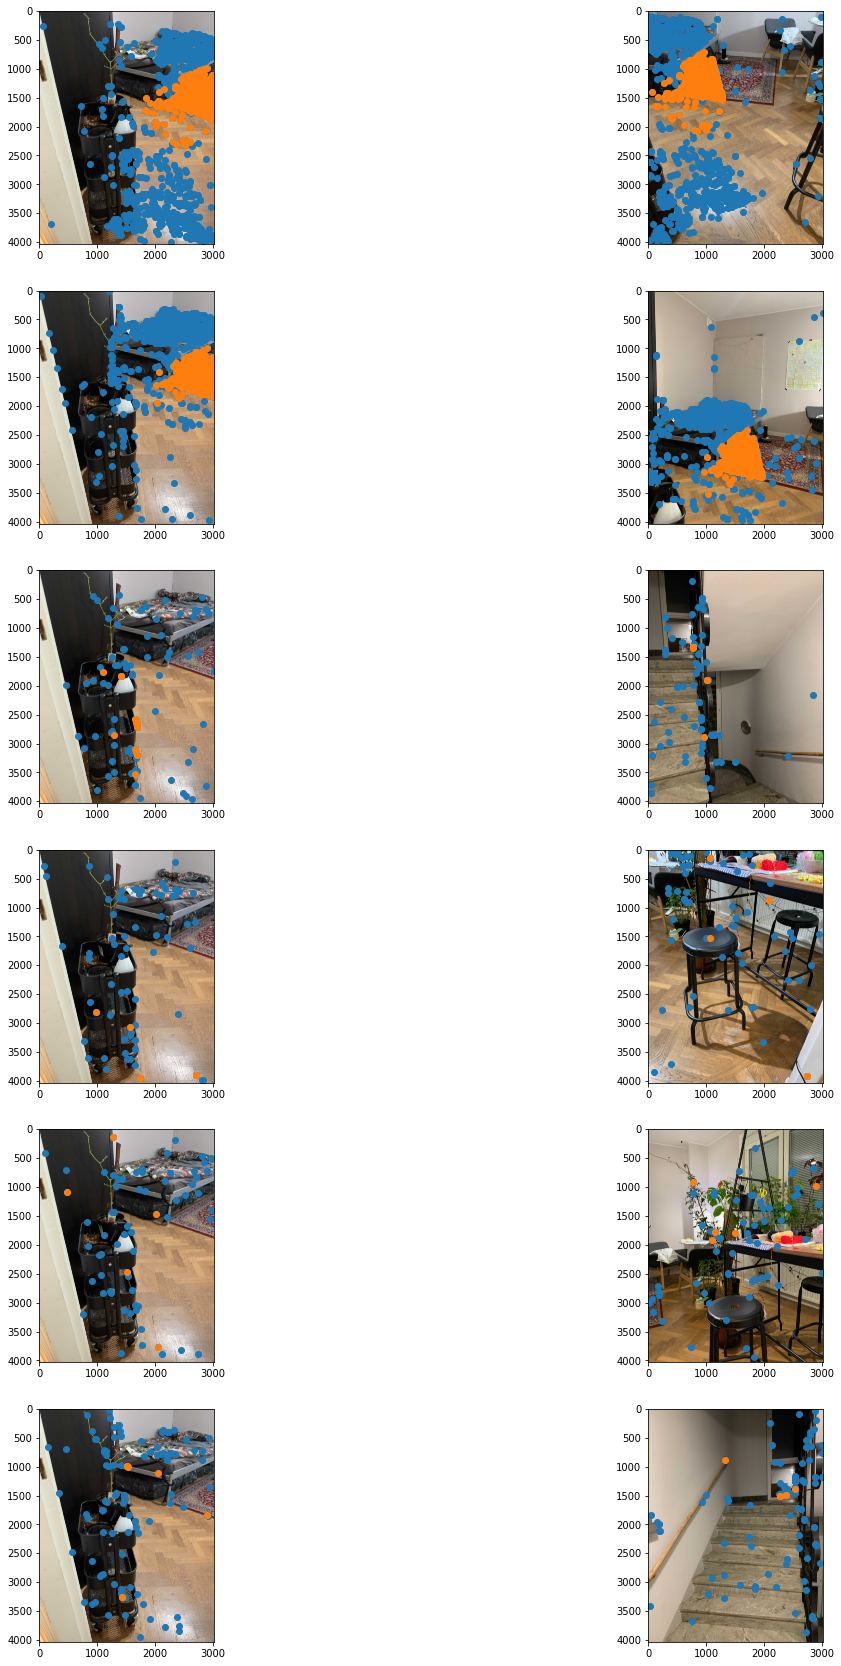

In [20]:
# Debug: for an image, display all matches and homographies
imgidx = 5
if debug:
    h_list = homographies[imgidx]
    img = images[imgidx][0]
    plt.figure(figsize=(5,10))
    plt.imshow(img)
    plt.show()
    print("matches")
    fig, axs = plt.subplots(len(h_list), 2, figsize=(20,30))
    for i, h_list in enumerate(homographies[imgidx]):
        
        k, H, mask, kp1, kp2 = h_list
        print(k, mask.mean(), mask.shape[0], ismatch(mask.sum(), mask.shape[0]))
        
        axs[i, 0].imshow(images[imgidx][0])
        axs[i, 0].scatter(*kp1.T)
        axs[i, 0].scatter(*kp1[mask.flatten().astype(bool)].T)
        
        axs[i, 1].imshow(images[k][0])
        axs[i, 1].scatter(*kp2.T)
        axs[i, 1].scatter(*kp2[mask.flatten().astype(bool)].T)
        
    fig.show()

All that remains to do is to compute the connected components from the pairwise matches.

In [21]:
# Build the list of pairwise matchings.
# To summarize:
# 1. We found the images that share the most features
# 2. We computed a Homography between them using matching features
# 3. We use the RANSAC statistics to decide if these images do indeed match.
directed_matches = [] #directed_matches[i] = indices of all matches to image i

for i, h_list in enumerate(homographies):
    curr_matches = []
    for (k, H, mask, kp1, kp2) in h_list:
        if ismatch(mask.sum(), mask.shape[0]):
            curr_matches.append(k)
    directed_matches.append(curr_matches)
  
directed_matches

[[2],
 [11],
 [0],
 [6, 7, 4],
 [9, 8, 5, 6, 7],
 [4, 9],
 [7, 8, 3, 4],
 [6, 8, 3, 4, 9],
 [7, 6, 9, 4, 3, 5],
 [4, 8, 5, 7],
 [],
 [1]]

In [22]:
# Get connected components from the matches
from collections import defaultdict

def get_connected_components(nodes):
    # Add all neighbors to the same group    
    visited = set()
    def _build_group(key, group):
        if key in visited:
            return
        visited.add(key)
        group.add(key)
        for k in nodes[key]:
            _build_group(k, group)

    groups = []
    for key in range(len(nodes)):
        if key in visited:
            continue
        groups.append(set())
        _build_group(key, groups[-1])

    return groups

matches_groups = get_connected_components(directed_matches)

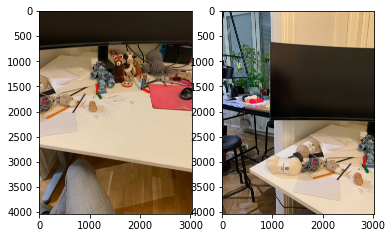

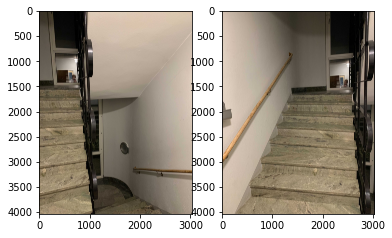

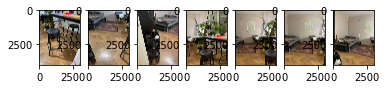

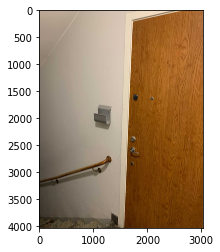

In [23]:
# Display the different connected components
if debug:
    for group in matches_groups:
        fig, ax = plt.subplots(1, len(group))
        for i, imgidx in enumerate(group):
            if len(group) > 1:
                ax[i].imshow(images[imgidx][IMAGE])
            else:
                ax.imshow(images[imgidx][IMAGE])
        fig.show()